# Letters

## Description

Generate an image with the edges of the letters present in this noisy image


## Group 9

* PG53879 - Inês Nogueira Ferreira
* PG54084 - Marta Isabel da Silva e Sá

### Inicialização

In [1768]:
import cv2
# to install cv2 use: pip install opencv-python
import matplotlib.pyplot as plt 
import numpy as np

(400, 600)


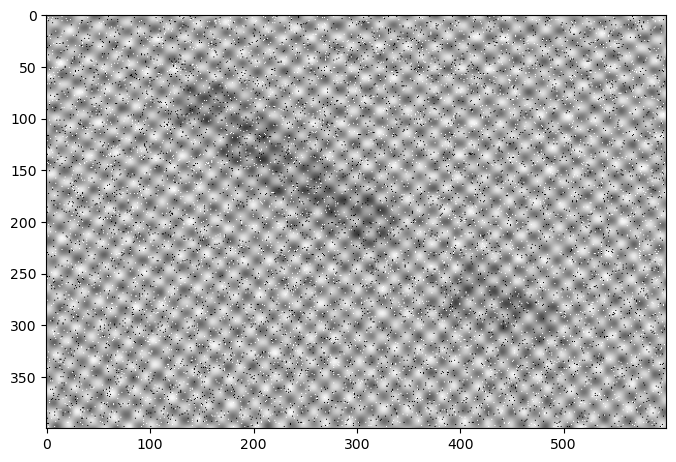

In [1769]:
fname = 'Letters-noisy.png'
img = cv2.imread(fname,cv2.IMREAD_GRAYSCALE)
W,H=img.shape
print(img.shape)
ratio=H/W
fig = plt.figure(figsize=(8,8*ratio))
plt.imshow(img, cmap='gray')

### Notch Filter

Começamos por aplicar o Notch Filter para reduzir o ruído periódico presente na imagem original. Desta forma, através da análise do espectro de magnitude, reparamos que existiam zonas de baixas frequências pelo que definimos manualmente vários filtros nas coordenanas destas zonas.

In [1770]:
# shape: (W,H) are the width and height of the filter

# d0 is the radius of the filter expressed in pixels

# u_k and v_k are the center coordinates in the Fourier image plane for the notch filter
# u_k=0, v_k=0 correspond to the center of the shifted spectrum

def notch_reject_filter_vec(shape: tuple[int, int], d0: int, u_k: int, v_k: int):
    (W, H) = shape

    H_0_u = np.repeat(np.arange(W), H).reshape((W, H))
    H_0_v = np.repeat(np.arange(H), W).reshape((H, W)).transpose()

    D_uv = np.sqrt((H_0_u - W / 2 + u_k) ** 2 + (H_0_v - H / 2 + v_k) ** 2)
    D_muv = np.sqrt((H_0_u - W / 2 - u_k) ** 2 + (H_0_v - H / 2 - v_k) ** 2)

    selector_1 = D_uv <= d0
    selector_2 = D_muv <= d0

    selector = np.logical_or(selector_1, selector_2)

    H = np.ones((W, H, 2), np.uint8)
    H[selector] = 0

    return H

DFT Shape = (400, 600, 2)


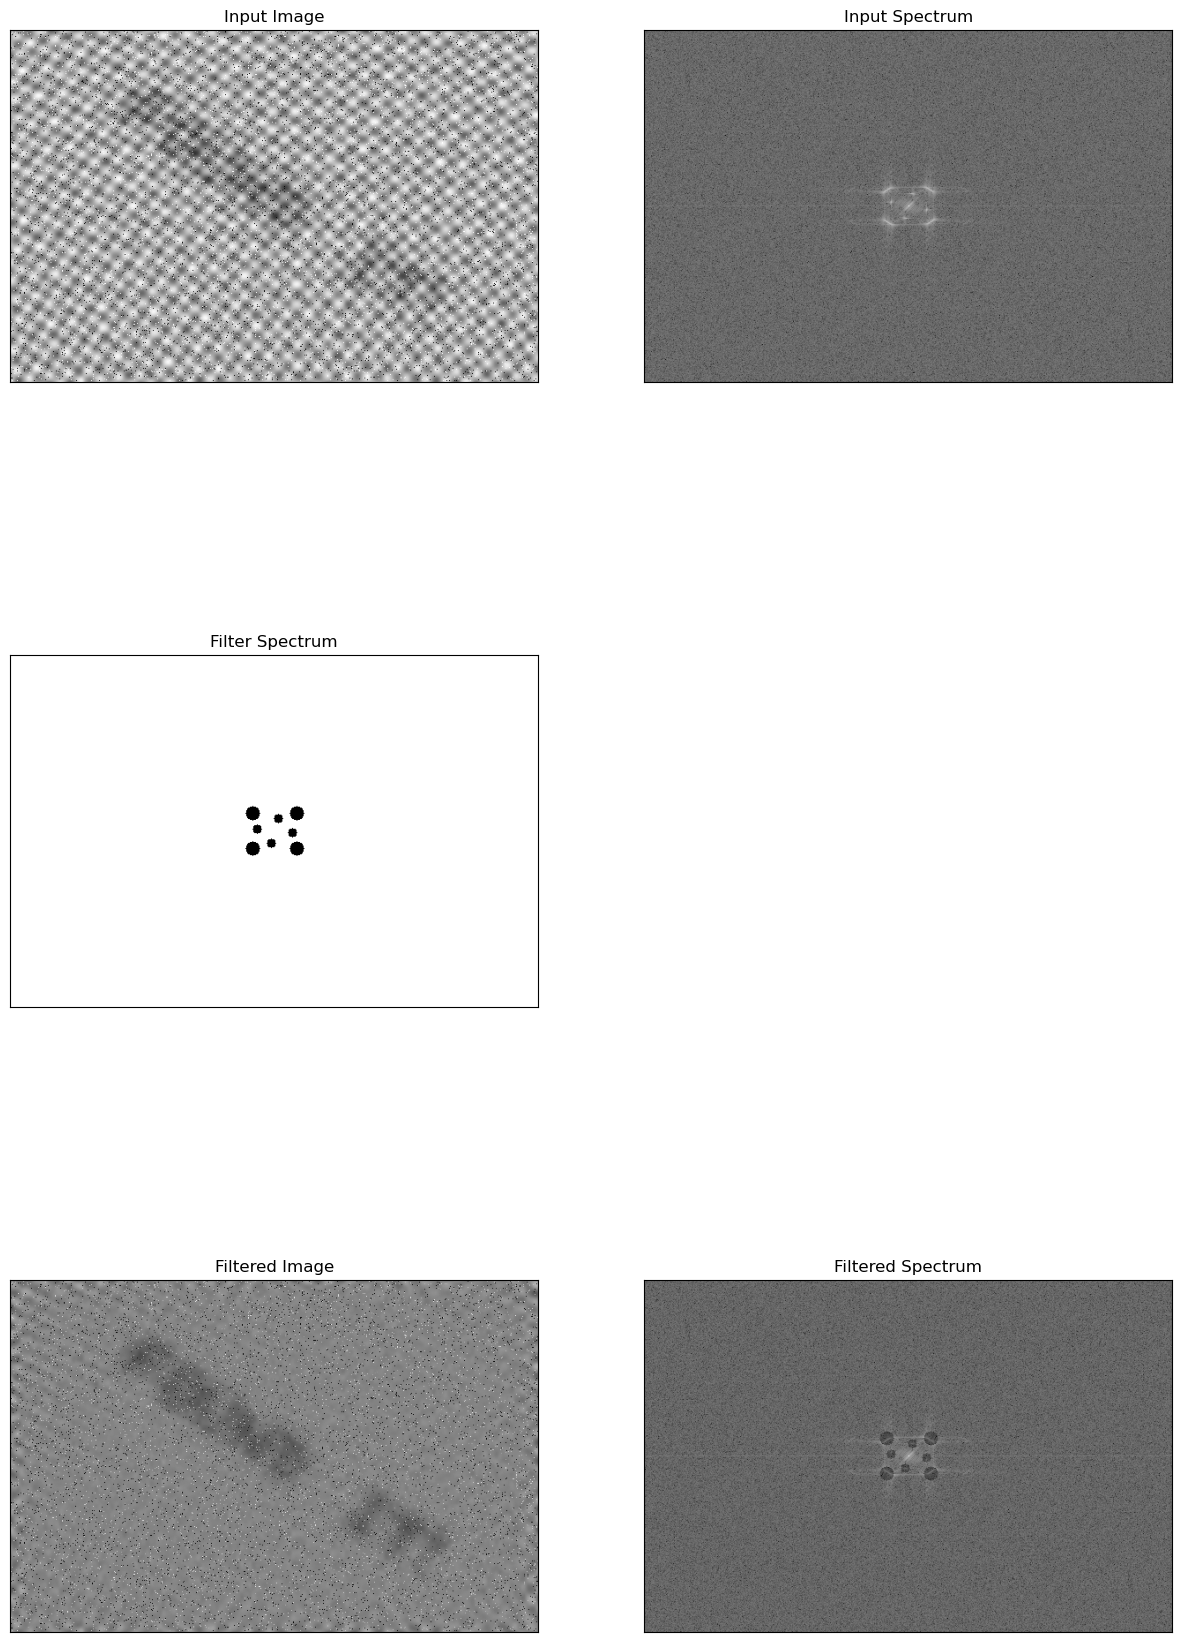

In [1771]:
img_float32 = np.float32(img)

# compute the DFT
# Note that the computed DFT has 2 channels :
# dft[:,:,0] - real values
# dft[:,:,1] - imaginary values
dft = cv2.dft(img_float32, flags = cv2.DFT_COMPLEX_OUTPUT)
# recenter the DFT , such that the center is (0,0)
dft_shift = np.fft.fftshift(dft)

print('DFT Shape =', dft_shift.shape)

# compute the frequency spectrum
# module of the complex value
magnitude_spectrum = cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1])
# compute the logarith of magnitude such that smaller values are visible
magnitude_spectrum = 20*np.log(magnitude_spectrum)

# several notch filters can be composited by multiplication

# fill in the following lists to compose multiple notch filters

d0_list = [8,8,5,5]                 # raio do nodo
u_k_list = [20,20,-2,14]            # coordenada u do nodo (y)
v_k_list = [25,-25,-20,-4]          # coordenada v do nodo (x)

H = notch_reject_filter_vec(img.shape, d0_list[0], u_k_list[0], v_k_list[0])

for d0, u_k, v_k in zip (d0_list[1:], u_k_list[1:], v_k_list[1:]):
    Haux = notch_reject_filter_vec(img.shape, d0, u_k, v_k)
    H *= Haux

# apply mask and inverse DFT<
dft_masked = dft_shift * H
# do not forget to undo the centering of the transform
dft_masked_ishift = np.fft.ifftshift(dft_masked)
img_back = cv2.idft(dft_masked_ishift)

# img_back should only have real values
# but let's make sure due to rounding and representation errors
img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])

# compute the DFT of the processed image (img_back)
# Note that the computed DFT has 2 channels :
# dft[:,:,0] - real values
# dft[:,:,1] - imaginary values
dft_proc = cv2.dft(img_back, flags = cv2.DFT_COMPLEX_OUTPUT)
# recenter the DFT , such that the center is (0,0)
dft_proc_shift = np.fft.fftshift(dft_proc)
# compute the frequency spectrum
# module of the complex value
filtered_spectrum = cv2.magnitude(dft_proc_shift[:,:,0],dft_proc_shift[:,:,1])
# compute the logarith of magnitude such that smaller values are visible
filtered_spectrum = 20*np.log(filtered_spectrum)

# compute the frequency spectrum of the MASK, 
# just for display purposes
# module of the complex value
mask_spectrum = np.sqrt(np.power(H[:,:,0],2)+np.power(H[:,:,1],2))
# compute the logarith of magnitude such that smaller values are visible
mask_spectrum = 20*np.log(mask_spectrum+0.0001)

# display the image and the spectrum
fig = plt.figure(figsize=(15,23))
plt.subplot(321),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(322),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Input Spectrum'), plt.xticks([]), plt.yticks([])
plt.subplot(323),plt.imshow(mask_spectrum, cmap = 'gray')
plt.title('Filter Spectrum'), plt.xticks([]), plt.yticks([])
plt.subplot(325),plt.imshow(img_back, cmap = 'gray')
plt.title('Filtered Image'), plt.xticks([]), plt.yticks([])
plt.subplot(326),plt.imshow(filtered_spectrum, cmap = 'gray')
plt.title('Filtered Spectrum'), plt.xticks([]), plt.yticks([])
plt.show() 



In [1772]:
img_back *= (255.0/img_back.max())
imgNotch = img_back.astype(np.uint8)

### Aplicação de diferentes tipos de Blur

Uma vez que a imagem resultante da aplicação do Notch Filter ainda apresentava algum optamos por aplicar diferentes tipos filtros que permitem a suavização da imagem: 
* Aplicamos o filtro da mediana porque achamos que ia destacar mais as letras; 
* Utilizamos o filtro Bilateral porque queriamos reduzir o ruido sem afetar os contornos das letras para, mais tarde, tentarmos técnicas de deteção de contornos;
* Tentamos também o Gaussian e o Fast Means Denoising para ter a certeza de que tentavamos o maior tipo de opções de blur possiveis. 

O melhor resultado acabou por ser obtido a partir de uma dupla aplicação do filtro Bilateral.

#### Gaussian Blur

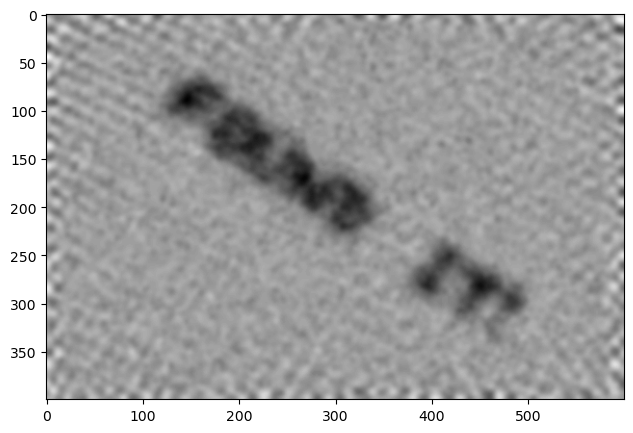

In [1773]:
m=17
img_gauss = cv2.GaussianBlur(imgNotch,(m,m),0)

fig = plt.figure(figsize=(15,5))
plt.imshow(img_gauss, cmap='gray')

#### Fast Means Denoising

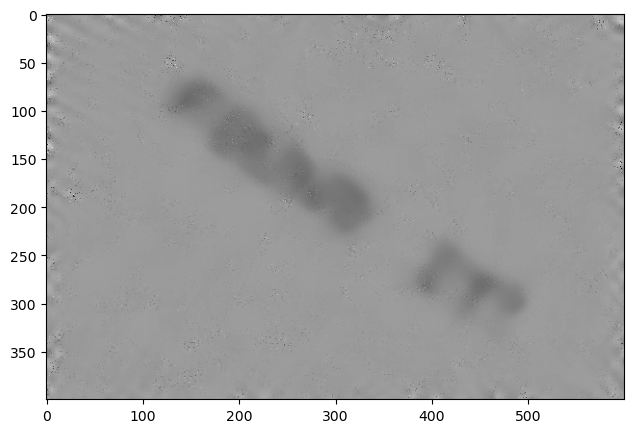

In [1774]:
# OpenCV Local Denoising Filter 
img_fast_means = cv2.fastNlMeansDenoising(imgNotch,None,15,15,31) # source, destination, h=15, hForColorComponents=27, templateWindowSize=51

fig = plt.figure(figsize=(15,5))
plt.imshow(img_fast_means, cmap='gray')

#### Median Filter

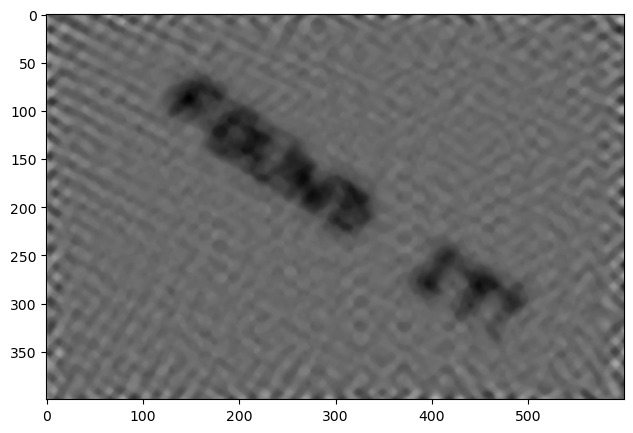

In [1775]:
# Filtro de Mediana
m=7
img_median = cv2.medianBlur(imgNotch,m,0)

fig = plt.figure(figsize=(15,5))
plt.imshow(img_median, cmap='gray')


#### Bilateral

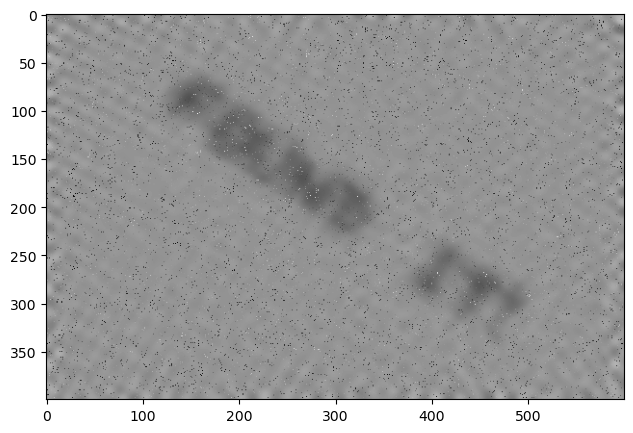

In [1776]:
# OpenCV Bilateral Filter 
m=13
sigma_s = 45
sigma_r = 175
img_bi = cv2.bilateralFilter(imgNotch, m, sigma_s, sigma_r)

fig = plt.figure(figsize=(15,5))
plt.imshow(img_bi, cmap='gray')

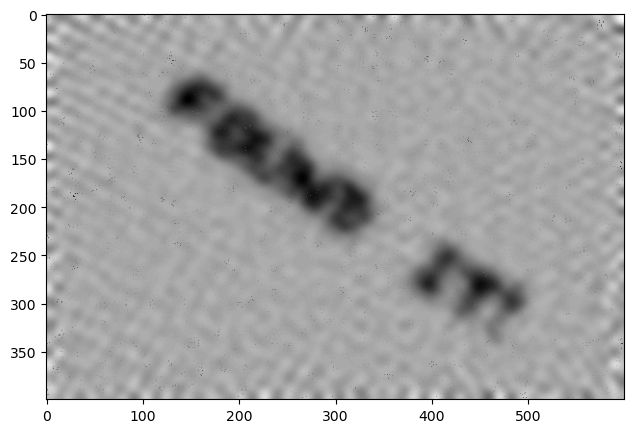

In [1777]:
# OpenCV Bilateral Filter 
m=13
sigma_s = 55
sigma_r = 175
img_bi2 = cv2.bilateralFilter(img_bi, m, sigma_s, sigma_r)

fig = plt.figure(figsize=(15,5))
plt.imshow(img_bi2, cmap='gray')

### Histogramas

Fizemos a analise do histograma com o objetivo de ver qual seria o melhor valor de threshold. E como sabemos as chances de selecionar um “bom” threshold aumentam consideravelmente se os picos do histograma forem altos, estreitos, simétricos e separados por vales profundos. E, uma vez que o nosso histograma não apresenta esse formato (apresentando apenas um pico decidimos), decidimos aplicar as técnicas de Laplace e de Sobel para que o histograma fica-se com um formato que ajudasse na escolha do threshold.

([], [])

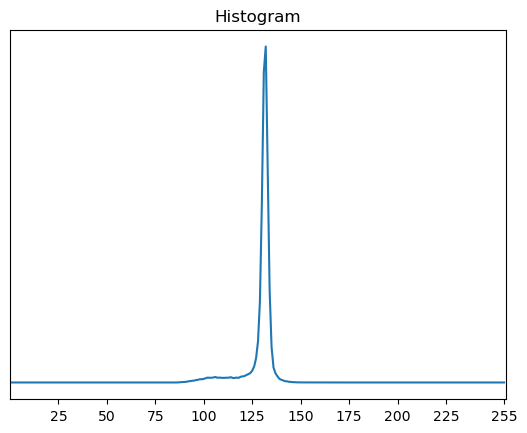

In [1778]:
# histogram
hist = cv2.calcHist([img_bi2],[0],None,[256],[0,256])


plt.plot(hist)
plt.xlim([0,256])
plt.title('Histogram')
plt.xticks([25,50,75,100,125,150,175,200,225,255]) 
plt.yticks([])

### Deteção de Linhas

Depois de utilizar o laplace e o Sobel, com várias tentativas de filtros, chegamos à conclusão que o Sobel apresentava melhores resultados apesar do histograma não ter ficado como esperávamos em nenhum dos casos apresentando em ambas as situações apenas um pico. Desta forma, aplicamos a máscara de Sobel à imagem para que os seus contornos fiquem realçados. 

#### Laplace

In [1779]:
def correlate(kernel, image):
    W = image.shape[0]
    H = image.shape[1]
    out =np.zeros((W,H))
    a = kernel.shape[0]%2
    b = kernel.shape[1]%2
    #print (a,b)
    for y in range(b,H-b): 
        for x in range(a,W-a): 
            for s in range (-a,a+1):
                for t in range (-b, b+1):
                    out[x,y] += (kernel[s,t]*image[x+s,y+t])
    return out

In [1780]:
def rescale(image):
    image = np.absolute(image)
    mymin=np.amin(image)
    mymax=np.amax(image)
    W = image.shape[0]
    H = image.shape[1]
    for y in range(H): 
        for x in range(W): 
            image[x,y] = (image[x,y]-mymin)*256/(mymax-mymin)
    return image

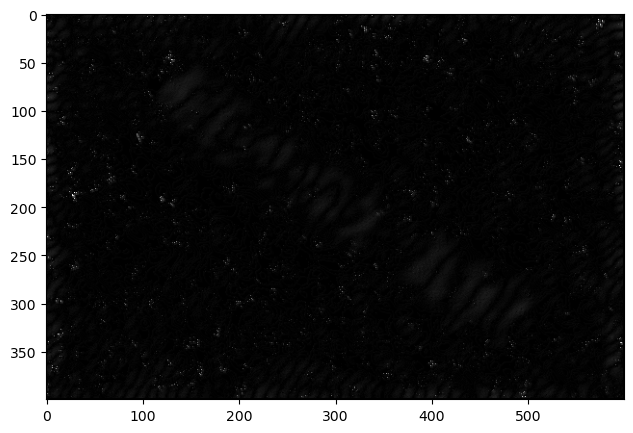

In [1781]:
LaplaceArray = np.array([[1,1,1],[1,-8,1],[1,1,1]], dtype=float)
#LaplaceArray = np.array([[0,-1,0], [-1, 4, -1],[0,-1,0]], dtype=float)
#LaplaceArray = np.array([[2,-1,-1], [-1, 2, -1],[-1,-1,2]], dtype=float)

Laplace = correlate(LaplaceArray, img_bi2)
Laplace = rescale(Laplace)

fig = plt.figure(figsize=(15,5))
plt.imshow(Laplace, cmap='gray')

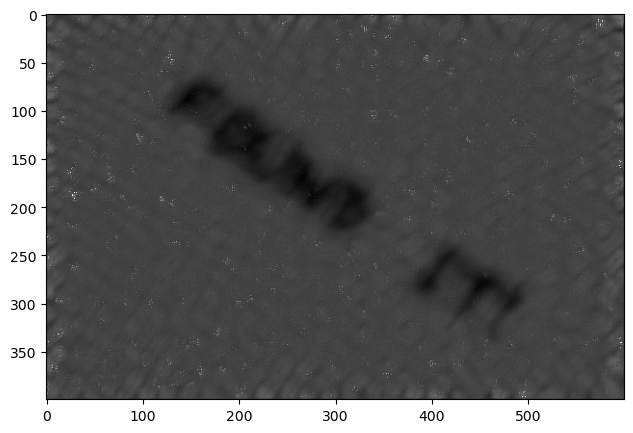

In [1782]:
c = 0.5
laplaceImg = img_bi2 + c*Laplace

fig = plt.figure(figsize=(15,5))
plt.imshow(laplaceImg, cmap='gray')

# Normalize the image
img_norm = cv2.normalize(laplaceImg, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8U)

#### Sobel

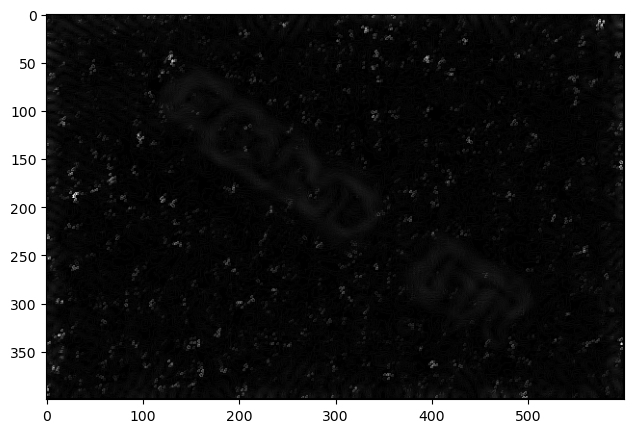

In [1783]:
Sobel_x = np.array([[-1,-2,-1], [0, 0, 0],[1,2,1]], dtype=float)
Sobel_y = np.array([[-1,0,1], [-2, 0, 2],[-1,0,1]], dtype=float)

gx = correlate(Sobel_x, img_bi2)
gx = np.absolute(gx)
gy = correlate(Sobel_y, img_bi2)
gy = np.absolute(gy)

grad = np.sqrt(np.square(gx) + np.square(gy))
fig = plt.figure(figsize=(15,5))
plt.imshow(grad, cmap='gray')

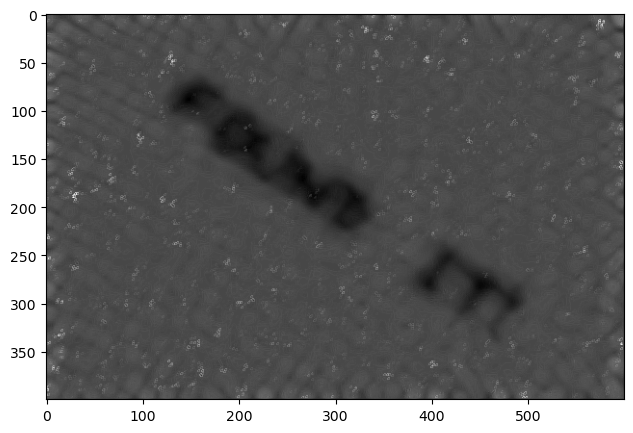

In [1784]:
c = 0.5
gradImg = c*img_bi2 + c*grad

fig = plt.figure(figsize=(15,5))
plt.imshow(gradImg, cmap='gray')

# Normalize the image
img_norm = cv2.normalize(gradImg, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8U)

### Thresholding

Por fim, aplicamos várias técnica de thresholding:

* Thresholding Global onde definimos um limite com base nos histogramas da imagem resultante dos tratamentos anteriores. Neste tipo de thresholding, os valores acima do limite definido serão brancos (255) e os restantes serão pretos (0);
* Thresholding de Otsu que determina um limite de threshold ótimo.  
* Thresholding Adaptativo, onde o valor de threshold varia localmente na imagem com base na média de cada pixel na vizinhança. Desta forma, o tamanho da vizinhança (75) e o parâmetro constante subtraído do valor médio (5), foram alterados de forma a obter os melhores resultados.

(Text(0.5, 1.0, 'Adaptive Thresholding'), ([], []), ([], []))

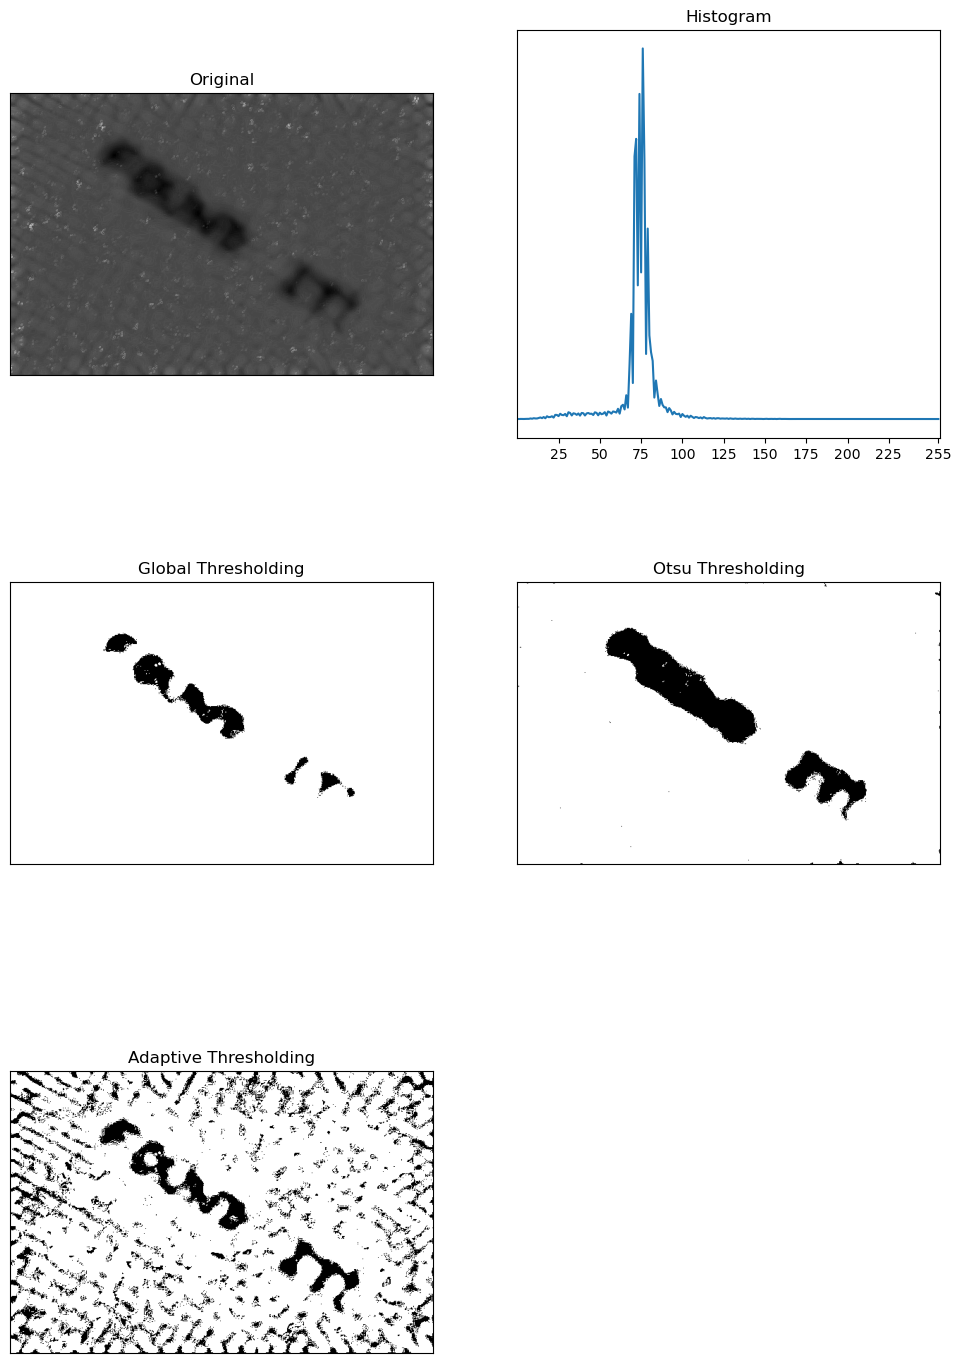

In [1785]:
# Histogram
hist = cv2.calcHist([img_norm],[0],None,[256],[0,256])

# Global
ret, Gthres = cv2.threshold(img_norm,35,255,cv2.THRESH_BINARY)

# Otsu thresholding
ret, Othres = cv2.threshold(img_norm,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Adaptive Thresholdinh
athres = cv2.adaptiveThreshold(img_norm,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,75,5) # source, max value, adaptive method, threshold type, block size, constant

fig = plt.figure(figsize=(12,18))
plt.subplot(3,2,1),plt.imshow(img_norm,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])

plt.subplot(3,2,2),plt.plot(hist),plt.xlim([0,256])
plt.title('Histogram'), plt.xticks([25,50,75,100,125,150,175,200,225,255]), plt.yticks([])

plt.subplot(3,2,3),plt.imshow(Gthres,cmap = 'gray')
plt.title('Global Thresholding'), plt.xticks([]), plt.yticks([])

plt.subplot(3,2,4),plt.imshow(Othres,cmap = 'gray')
plt.title('Otsu Thresholding'), plt.xticks([]), plt.yticks([])

plt.subplot(3,2,5),plt.imshow(athres,cmap = 'gray')
plt.title('Adaptive Thresholding'), plt.xticks([]), plt.yticks([])

Como podemos observar pelos resultados obtidos, a melhor técnica de thresholding foi a técnica adapatativa. Desta forma, apesar de ainda apresentar algum ruído, podemos verificar que as letras escondidas representam a frase "FOUND IT!".